# Melanoma Detection with Convolutional Neural Network

This is sample code that will ultimately be used in the Hoffman2 Linux Compute Cluster to make use of UCLA's high performance cloud computing resources like GPU requests and 64GB memory. 

Note: This sample code uses CPU only!

## Load Libraries

In [5]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## Exploratory Data Analysis

In [6]:
mel_df = pd.read_csv(os.path.join('sample_data', 'sample_data_gt.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

Proportion of positives: 0.01762965646320111


## CNN Mark \#1

We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [7]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, start_ind=0, transform=None):
        self.img_dir = img_dir
        self.start_ind = start_ind
        self.end_ind = start_ind+100
        
        mel_df = pd.read_csv(patientfile) 
        
        if self.end_ind > len(mel_df):
            self.end_ind = len(mel_df)
        
        mel_df = mel_df[self.start_ind:self.end_ind]
        self.gt = mel_df['target']
        self.isic_id = mel_df['image_name']
        #print(self.isic_id)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [8]:
# helper function for padding images one at a time
def pad2d_4k6k(_image):

    rows = _image.shape[1]
    cols = _image.shape[2]

    top = np.ceil((4000 - rows)/2).astype('int')
    bottom = np.floor((4000 - rows)/2).astype('int')
    right = np.ceil((6000 - cols)/2).astype('int')
    left = np.floor((6000 - cols)/2).astype('int')

    pad_func = nn.ConstantPad2d((left, right, top, bottom), 0)
    
    return pad_func(_image)


# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
    
        pad_image = pad2d_4k6k(_image)
        
        image_list.append(torch.unsqueeze(pad_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out

In [9]:
testing = False

transf = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ISICDatasetImages(img_dir=os.path.join("sample_data", "sample_jpgs"), 
                            patientfile=os.path.join("sample_data", "sample_data_gt.csv"), 
                            start_ind=0, transform=transf)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=pad_collate2d)


# test DataLoader with custom settings
if testing:
    for imgs, labels in data_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels has shape: ", labels.shape)

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

Size: torch.Size([10, 3, 4000, 6000])


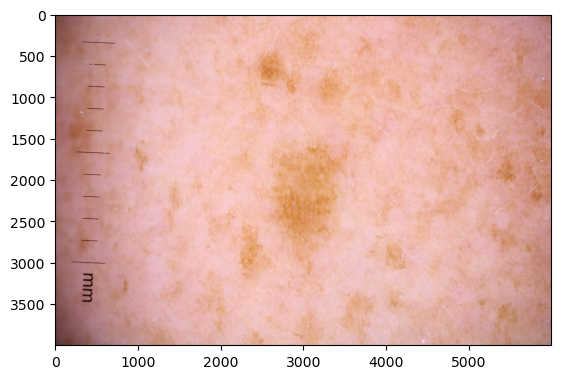

Label: Benign


In [10]:
# functions to show the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

# get some random training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
print("Size:", images.shape)


# show images
imshow(images[0,])

# print labels
print("Label:", label_id[labels[0,]])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        '''
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        '''
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        print(x.shape)
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = self.pool(x)
        print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.relu(self.fc2(x))
        print(x.shape)
        x = self.fc3(x)
        print(x.shape)
        return x


net = Net()
fake_data = torch.randn(10, 3, 32, 32)
out = net.forward(fake_data)
#print(fake_data.device)
#net.cuda()
#fake_data = fake_data.cuda()
#print(fake_data.device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
start_time = time.time()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs = inputs.cuda()
        #labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0 and i != 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training', time.time() - start_time)

In [ ]:
PATH = './melanoma_cnn.pth'
torch.save(net.state_dict(), PATH)